<font face = "times new roman">
<center>
<img src = "https://javier.rodriguez.org.mx/itesm/2014/tecnologico-de-monterrey-blue.png" width = "250">
<h3></h3>
<h3>Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning</h3>
<h3>Daniel Alejandro Martínez Cienfuegos - A01745412</h3>
<h3>Inteligencia artificial avanzada para la ciencia de datos II </h3>
<h3>TC3007C.501</h3>
<h3>Profesora - Julio Guillermo Arriaga Blumenkron</h3>
<h3>08/11/2024</h3>
</center>
</font>

**Introducción**

El presente proyecto aborda el problema de predecir el porcentaje de votos demócratas en diferentes regiones de los Estados Unidos utilizando un modelo de aprendizaje profundo. Este tipo de predicción es relevante porque proporciona una herramienta para entender patrones electorales y podría ayudar a anticipar resultados futuros en procesos democráticos. Los patrones de votación están influenciados por factores demográficos, económicos y sociales que pueden ser analizados y modelados matemáticamente. Al desarrollar un modelo que aprende de estos datos, se exploran las complejas relaciones entre estas variables y su impacto en los resultados electorales, lo que podría ser de interés tanto para científicos de datos como para analistas políticos.


In [1]:
!pip install tensorflow
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


In [3]:
from google.colab import files
uploaded = files.upload()
election_data = pd.read_csv('US_Election_dataset_v1.csv')

election_data.head()

Saving US_Election_dataset_v1.csv to US_Election_dataset_v1.csv


,Unnamed: 0,county,state,2020 Democrat vote raw,2020 Democrat vote %,2020 Republican vote raw,2020 Republican vote %,2020 other vote raw,2020 other vote %,Population with less than 9th grade education,...,NH-American Indian and Alaska Native percentage,NH-Asian percentage,NH-Native Hawaiian and Other Pacific Islander percentage,NH-Some Other Race percentage,NH-Two or More Races percentage,"Percentage engaged in Management, business, science, and arts occupations",Percentage engaged in Service Occupations,Percentage engaged in Sales and Office,Percentage engaged in Resources and Construction,Percentage engaged in Transportation
0,"Autauga County, Alabama",Autauga County,Alabama,7503,27.02,19838,71.44,429,1.54,1.70%,...,0.31,1.48,0.04,0.31,4.23,36.39,14.24,22.02,9.99,17.36
1,"Baldwin County, Alabama",Baldwin County,Alabama,24578,22.41,83544,76.17,1557,1.42,2.00%,...,0.56,0.88,0.05,0.33,4.47,35.62,17.14,24.20,9.91,13.13
2,"Barbour County, Alabama",Barbour County,Alabama,4816,45.79,5622,53.45,80,0.76,7.30%,...,0.23,0.41,0.00,0.25,2.19,27.73,20.16,19.49,12.53,20.09
3,"Bibb County, Alabama",Bibb County,Alabama,1986,20.70,7525,78.43,84,0.88,6.40%,...,0.17,0.12,0.04,0.21,2.69,22.22,15.32,20.57,16.43,25.47
4,"Blount County, Alabama",Blount County,Alabama,2640,9.57,24711,89.57,237,0.86,7.10%,...,0.32,0.29,0.02,0.17,3.89,26.75,12.98,22.73,15.81,21.73


**Datos**

Los datos utilizados en este proyecto fueron obtenidos de Kaggle (essarabi, 2020) y corresponden a un conjunto de datos con información detallada sobre características demográficas, económicas y resultados electorales en distintas regiones de Estados Unidos. Este conjunto de datos incluye columnas con la proporción de votos demócratas, republicanos y de otros partidos, así como variables demográficas que incluyen niveles de educación, ingresos medios y ocupaciones, entre otras.



In [4]:
print(election_data.columns)

Index(['Unnamed: 0', 'county', 'state', '2020 Democrat vote raw',
       '2020 Democrat vote %', '2020 Republican vote raw',
       '2020 Republican vote %', '2020 other vote raw', '2020 other vote %',
       'Population with less than 9th grade education',
       'Population with 9th to 12th grade education, no diploma',
       'High School graduate and equivalent', 'Some College,No Degree',
       'Associates Degree', 'Bachelors Degree',
       'Graduate or professional degree', 'Gini Index',
       'Median income (dollars)', 'Mean income (dollars)', 'Area in square Km',
       'Density per square km', 'Total Population',
       'Hispanic or Latino percentage', 'NH-White percentage',
       'NH-Black percentage',
       'NH-American Indian and Alaska Native percentage',
       'NH-Asian percentage',
       'NH-Native Hawaiian and Other Pacific Islander percentage',
       'NH-Some Other Race percentage', 'NH-Two or More Races percentage',
       'Percentage engaged in Management, bus

**Análisis y Preprocesamiento de los Datos**

Se realizó un análisis exploratorio detallado para garantizar que los datos estuvieran en un formato adecuado para el modelo. Durante este proceso, se identificaron valores nulos en algunas columnas numéricas y se implementaron estrategias de imputación, como el reemplazo de valores faltantes por el promedio de cada columna. Esto permitió aprovechar al máximo los datos disponibles sin descartar información valiosa.

Asimismo, las columnas categóricas presentes originalmente en el dataset, como state, fueron eliminadas del conjunto de características debido a su irrelevancia directa para la predicción del objetivo y para evitar introducir ruido en el modelo. Las columnas numéricas que contenían caracteres no numéricos (como comas o signos de porcentaje) fueron limpiadas para garantizar su correcta interpretación como valores continuos. Esta limpieza incluyó la conversión a formato numérico, reemplazando valores inválidos por NaN y aplicando imputación cuando fue necesario.

Además, todas las columnas relacionadas directamente con el valor objetivo (por ejemplo, "2020 Democrat vote raw", "2020 Republican vote %") fueron eliminadas del conjunto de características para evitar una filtración de información que comprometiera la integridad de las predicciones. Esta medida asegura que el modelo solo utilice datos disponibles previamente al evento que se desea predecir.

In [5]:
columns_to_remove = [
    '2020 Democrat vote raw',
    '2020 Democrat vote %',
    '2020 Republican vote raw',
    '2020 Republican vote %',
    '2020 other vote raw',
    '2020 other vote %',
    'Unnamed: 0',
    'county',
    'state'
]

In [6]:
target_column = '2020 Democrat vote %'

X = election_data.drop(columns=columns_to_remove)
y = election_data[target_column]

In [7]:
# Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_preprocessor, numerical_columns)
])

In [8]:
# Preprocesar
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


**Desarrollo del Modelo**

El modelo implementado es una red neuronal profunda basada en un Perceptrón Multicapa (MLP), diseñada para capturar relaciones complejas entre las características demográficas, económicas y sociales del conjunto de datos. La arquitectura de la red incluye una capa de entrada adaptada al número de características preprocesadas, lo que permite al modelo recibir toda la información relevante tras las transformaciones aplicadas a los datos. Posteriormente, la red cuenta con dos capas ocultas, configuradas con 128 y 64 neuronas respectivamente, cada una con una activación ReLU que facilita el aprendizaje de patrones no lineales en los datos. Estas capas permiten al modelo aprender representaciones jerárquicas y reducir gradualmente la dimensionalidad para evitar el sobreajuste.

La capa de salida está compuesta por una única neurona, cuya activación sigmoid restringe los valores predichos al rango [0, 1]. Esto resulta adecuado para predecir el porcentaje de votos demócratas, ya que los valores pueden escalarse al rango [0, 100] para interpretarlos como porcentajes. Esta arquitectura combina flexibilidad y simplicidad, asegurando que el modelo pueda capturar patrones complejos mientras se mantiene eficiente.

In [9]:
# Modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Ajuste del Modelo**

El modelo fue entrenado utilizando la función de pérdida Error Cuadrático Medio (MSE), que mide la diferencia promedio al cuadrado entre las predicciones y los valores reales. Esta función de pérdida es adecuada para problemas de regresión, ya que penaliza errores grandes de manera más severa. Adicionalmente, se utilizó la métrica Error Absoluto Medio (MAE) para interpretar el desempeño del modelo en términos de la magnitud promedio del error, proporcionando una evaluación más intuitiva de la precisión. El entrenamiento se realizó utilizando el optimizador Adam, conocido por su capacidad para ajustar dinámicamente la tasa de aprendizaje durante el proceso de optimización. Para mejorar la capacidad de generalización del modelo y prevenir el sobreajuste, se implementaron técnicas de regularización como Dropout, que elimina conexiones aleatorias entre neuronas durante el entrenamiento, y BatchNormalization, que estabiliza la distribución de los datos a cada capa, acelerando el aprendizaje.

El modelo fue entrenado durante un máximo de 100 épocas, con un tamaño de lote (batch_size) de 32 muestras. Se incorporaron técnicas avanzadas para optimizar el proceso de entrenamiento, como EarlyStopping, que detuvo el entrenamiento si la pérdida en el conjunto de validación no mejoraba después de 10 épocas consecutivas, y ReduceLROnPlateau, que redujo la tasa de aprendizaje cuando el progreso del modelo se estancaba. Además, se utilizó ModelCheckpoint para guardar la mejor versión del modelo basado en la pérdida de validación.

In [10]:
# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
history = model.fit(
    X_train_scaled, y_train / 100,
    validation_data=(X_test_scaled, y_test / 100),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0656 - mae: 0.2008 - val_loss: 0.0136 - val_mae: 0.0966 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - mae: 0.1406 - val_loss: 0.0118 - val_mae: 0.0894 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - mae: 0.1213 - val_loss: 0.0101 - val_mae: 0.0805 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - mae: 0.1099 - val_loss: 0.0094 - val_mae: 0.0775 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - mae: 0.1002 - val_loss: 0.0090 - val_mae: 0.0748 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0983 - val_loss: 0.0092 - val_mae: 0.0760 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - mae: 0.0889 - val_loss: 0.0087 - val_mae: 0.0731 - learning_rate: 0.0010
Epoch 8/100
7

In [12]:
# Evaluación
test_loss, test_mae = model.evaluate(X_test_scaled, y_test / 100, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae * 100}")


Test Loss: 0.008521296083927155, Test MAE: 7.354415953159332


**Resultados**

El modelo final fue evaluado en el conjunto de prueba, y los resultados mostraron una reducción significativa en la métrica de error medio absoluto (MAE) en comparación con las evaluaciones iniciales. Los valores de predicción generados por el modelo mostraron una correlación alta con los valores reales, lo que indica que el modelo es capaz de capturar los patrones en los datos subyacentes de manera efectiva. Se generaron gráficos de comparación entre las predicciones del modelo y los valores reales, los cuales muestran una alineación aceptable entre ambas series. Este resultado valida la efectividad del modelo para realizar predicciones razonablemente precisas en el contexto electoral.

In [13]:
predictions = model.predict(X_test_scaled) * 100
print("Algunas predicciones:", predictions[:5].flatten())
for i, pred in enumerate(predictions[:5], 1):
    print(f"El valor {pred[0]:.2f} indica que el modelo predice un {pred[0]:.2f}% de votos demócratas en la región {i} del conjunto de prueba.")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Algunas predicciones: [22.709066 51.424236 29.812223 34.277515 48.472195]
El valor 22.71 indica que el modelo predice un 22.71% de votos demócratas en la región 1 del conjunto de prueba.
El valor 51.42 indica que el modelo predice un 51.42% de votos demócratas en la región 2 del conjunto de prueba.
El valor 29.81 indica que el modelo predice un 29.81% de votos demócratas en la región 3 del conjunto de prueba.
El valor 34.28 indica que el modelo predice un 34.28% de votos demócratas en la región 4 del conjunto de prueba.
El valor 48.47 indica que el modelo predice un 48.47% de votos demócratas en la región 5 del conjunto de prueba.


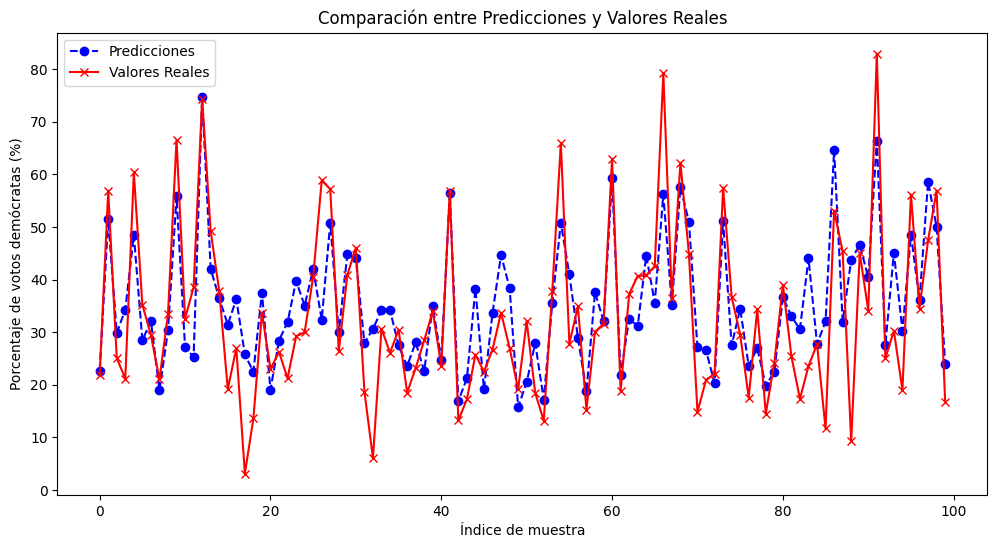

In [14]:
n_samples = 100
plt.figure(figsize=(12, 6))
plt.plot(predictions[:n_samples], label='Predicciones', marker='o', color='blue', linestyle='dashed')
plt.plot(y_test[:n_samples].reset_index(drop=True), label='Valores Reales', marker='x', color='red', linestyle='solid')

plt.title('Comparación entre Predicciones y Valores Reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Porcentaje de votos demócratas (%)')
plt.legend()
plt.show()

**Conclusiones**

Los resultados obtenidos demuestran que el modelo desarrollado es una herramienta eficaz para predecir el porcentaje de votos demócratas en distintas regiones, con una precisión razonable. Sin embargo, hay áreas en las que se podría mejorar el modelo. Por ejemplo, se podría explorar la adición de variables adicionales que capturen mejor las dinámicas locales, como variables de contexto político, histórico o cultural. Además, la implementación de modelos más complejos, como redes neuronales recurrentes (RNNs) o técnicas de ensamblado con otros modelos de aprendizaje automático, podría ofrecer una mayor precisión. La optimización de los hiperparámetros mediante técnicas más avanzadas, como la búsqueda en cuadrícula o el uso de algoritmos genéticos, también representa una posible mejora en el rendimiento del modelo.

**Aplicación**

Se desarrolló una función para realizar predicciones del porcentaje de votos demócratas utilizando el modelo ajustado y entrenado. Esta función permite ingresar nuevas muestras de datos, procesarlas de manera consistente con el preprocesamiento aplicado al conjunto de datos original y generar predicciones basadas en los patrones aprendidos por el modelo. El proceso de predicción comienza transformando los datos de entrada en un formato que el modelo pueda interpretar. Esto incluye convertir los datos en un DataFrame y asegurarse de que las columnas coincidan con las del conjunto de entrenamiento. Las columnas faltantes se rellenan con ceros para mantener la estructura esperada. Aunque las columnas categóricas como state fueron eliminadas durante el preprocesamiento inicial, si estuvieran presentes en el conjunto de datos, se aplicarían transformaciones adicionales, como la codificación numérica mediante un LabelEncoder.

Posteriormente, las columnas de texto se limpian para eliminar caracteres no numéricos, como comas, signos de porcentaje y valores inválidos (-). Esta limpieza asegura que los datos puedan ser procesados correctamente. Cualquier valor faltante después de este proceso se completa utilizando el promedio de la columna, manteniendo la coherencia con la estrategia de imputación implementada durante el preprocesamiento original. Una vez preparados, los datos se escalan utilizando el pipeline de preprocesamiento previamente definido. Este escalado garantiza que las características de entrada estén normalizadas, lo que es crucial para obtener predicciones consistentes del modelo.

El modelo predice el porcentaje de votos demócratas como un valor entre 0 y 1 gracias a la activación sigmoid en la capa de salida. Este resultado se escala al rango [0, 100] para interpretarlo como un porcentaje. Finalmente, la predicción se devuelve como la estimación del modelo para el porcentaje de votos demócratas basado en las características ingresadas.

In [15]:
model_tuned = model

def predict_democrat_vote_percentage(input_data):
    input_data = pd.DataFrame([input_data])
    X_train_columns = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]
    input_data = input_data.reindex(columns=X_train_columns, fill_value=0)
    if 'state' in input_data.columns:
        input_data['state'] = LabelEncoder().fit_transform(input_data['state'])

    # Limpieza de columnas de texto
    for col in input_data.columns:
        if input_data[col].dtype == 'object':
            input_data[col] = (
                input_data[col]
                .str.replace(',', '')
                .str.replace('%', '')
                .replace('-', np.nan)
                .astype(float)
            )

    input_data.fillna(input_data.mean(), inplace=True)

    # Preprocesar usando el pipeline creado anteriormente
    input_data_scaled = preprocessor.transform(input_data)

    # Predicción
    prediction = model_tuned.predict(input_data_scaled)

    # Escalar el resultado de vuelta al rango original (0-100)
    return prediction[0] * 100

# Ejemplo
nueva_muestra = {
    "Population with less than 9th grade education": 2000,
    "Population with 9th to 12th grade education, no diploma": 1500,
    "High School graduate and equivalent": 10000,
    "Some College,No Degree": 8000,
    "Associates Degree": 3000,
    "Bachelors Degree": 5000,
    "Graduate or professional degree": 2000,
    "Gini Index": 0.45,
    "Median income (dollars)": 35000,
    "Mean income (dollars)": 45000,
    "Area in square Km": 100,
    "Density per square km": 500,
    "Total Population": 150000,
    "Hispanic or Latino percentage": 0.1,
    "NH-White percentage": 0.8,
    "NH-Black percentage": 0.1,
    # Añadir otras columnas relevantes...
}

print("Predicción de voto demócrata para la nueva muestra:", predict_democrat_vote_percentage(nueva_muestra))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicción de voto demócrata para la nueva muestra: [45.235317]


**Bibliografía**

essarabi. (2020). US Election Dataset. Kaggle.com. https://www.kaggle.com/datasets/essarabi/ultimate-us-election-dataset

‌